#INGESTA DE DATOS

In [3]:
!pip install opendatasets
import opendatasets as od
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#Dataset
Para este notebook se trabajara con un dataset llamado Drug Classification, en el cual el objetivo que tendremos que clasificar que tipo de droga es si:[A,B,C,X,Y] dado ciertas caracterirsticas y efectos que estas tienen en un grupo de personas, ademas vamos a intentar descubrir el numero optimo de estimadores en el cado del RandomForestClassifier y la maxima profundidad para el DecisionTreeClassifier.

In [4]:
datasetlink = "https://www.kaggle.com/datasets/prathamtripathi/drug-classification"
od.download(datasetlink)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kidkeozz
Your Kaggle Key: ··········


100%|██████████| 1.68k/1.68k [00:00<00:00, 996kB/s]

In [5]:
os.chdir("drug-classification")
os.listdir()

['drug200.csv']

#Damos un vistazo a los datos
para obtener un poco mas de informmación acerca de su distribución y algunos datos que puedan tener en común para poder darnos una mejor idea de con que estamos trabajando

In [6]:
archivo = 'drug200.csv'
df = pd.read_csv(archivo)
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [7]:
df.shape

(200, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


#Renombramos las columnas
Esto es a gusto de cada quien pero lo hice para poder dar algo más de informacion de que trata cada columna

In [9]:
df.rename(columns={'BP':'Blood Pressure Levels'},inplace=True)

In [10]:
df.rename(columns={'Na_to_K':'Na to Potassium Ration'},inplace=True)

Aqui ya empezamos a notar que la drogaY es la que mas se encuentra presente o la mas recurrente en este dataset, por lo cual tenemos que tener cuidado a la hopra de dividir los datos para que puedan conservar una distribucion parecida a esta al momento de realizar el entrenamiento.

In [11]:
df['Drug'].value_counts()

DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64

#Tratamos las variables categoricas
Las transformamos a variables numericas asignandole un numero a cada tipo de clase, haciendo un mapeo sencillo.

In [12]:
drugs_mapping = {'DrugY':0,'drugX':1,'drugA':2,'drugC':3,'drugB':4 }
df['Drug'] = df['Drug'].map(drugs_mapping)
df.head()

,Age,Sex,Blood Pressure Levels,Cholesterol,Na to Potassium Ration,Drug
0,23,F,HIGH,HIGH,25.355,0
1,47,M,LOW,HIGH,13.093,3
2,47,M,LOW,HIGH,10.114,3
3,28,F,NORMAL,HIGH,7.798,1
4,61,F,LOW,HIGH,18.043,0


#Analizamos las demás características
Ahora si podemos ver una distribución más equilibrada en la mayoria de las categorias

In [13]:
df['Cholesterol'].value_counts()

HIGH      103
NORMAL     97
Name: Cholesterol, dtype: int64

In [14]:
df['Blood Pressure Levels'].value_counts()

HIGH      77
LOW       64
NORMAL    59
Name: Blood Pressure Levels, dtype: int64

#Transformamos las demás características
Hacemos un mapeo básico como lo hicimos con la columna drugs, esto es posible hacerlo con un label_encoder, sin embargo por las circustancias y pocas características no lo vi tan necesario, sin embargo es posible hacerlo.

In [15]:
BP_mapping = {'HIGH': 0 , 'LOW':1, 'NORMAL':2}
df['Blood Pressure Levels'] = df['Blood Pressure Levels'].map(BP_mapping)
df.head()

,Age,Sex,Blood Pressure Levels,Cholesterol,Na to Potassium Ration,Drug
0,23,F,0,HIGH,25.355,0
1,47,M,1,HIGH,13.093,3
2,47,M,1,HIGH,10.114,3
3,28,F,2,HIGH,7.798,1
4,61,F,1,HIGH,18.043,0


In [16]:
Cholesterol_mapping = {'HIGH': 0 ,'NORMAL':1}
df['Cholesterol'] = df['Cholesterol'].map(Cholesterol_mapping)
df.head()

,Age,Sex,Blood Pressure Levels,Cholesterol,Na to Potassium Ration,Drug
0,23,F,0,0,25.355,0
1,47,M,1,0,13.093,3
2,47,M,1,0,10.114,3
3,28,F,2,0,7.798,1
4,61,F,1,0,18.043,0


In [17]:
sex_mapping = {'M': 0 ,'F':1}
df['Sex'] = df['Sex'].map(sex_mapping)
df.head()

,Age,Sex,Blood Pressure Levels,Cholesterol,Na to Potassium Ration,Drug
0,23,1,0,0,25.355,0
1,47,0,1,0,13.093,3
2,47,0,1,0,10.114,3
3,28,1,2,0,7.798,1
4,61,1,1,0,18.043,0


#Dividimos los datos
Esto para tener claro cual es nuestra variable a predecir y nuestras caracteristicas predictoras

In [18]:
X = df.drop(columns='Drug')
y = df['Drug']

#Probamos el modelo RandomForestClassifier variando el número de estimadores
Para esto creamos 2 diccionarios donde se van a guardar las metricas de la precision del modelo con los datos de prueba y con los de test, seleccionamos un rango de de valores en los que queremos que varie el numero de estimadores que determinara el numero de arboles que tendra el bosque y asu vez dandole más capacidad al modelo, luego iteramos dividiendo los datos de manera que conserven la distribucion del dataset original esto con el parametro stratify, y por ultimo solo variamos el parametro y hacemos las respectivas pruebas y almacenamos sus valores.

In [19]:
train_accuracies = {}
test_accuracies = {}
sizes = [10,20,30,40,50]
for size in sizes:
  X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.25, random_state=42, stratify=y)
  rf_classifier = RandomForestClassifier(n_estimators=size, random_state=42)
  rf_classifier.fit(X_train, y_train)
  train_accuracies[size] = rf_classifier.score(X_train, y_train)
  test_accuracies[size] = rf_classifier.score(X_test, y_test)

In [20]:
train_accuracies

{10: 0.9933333333333333, 20: 1.0, 30: 1.0, 40: 1.0, 50: 1.0}

#Deducción:
por lo que se ve en la grafica se puede intuir que el numero de estimadores para que el modelo trabaje en ambos datasets de manera optima es de aproximadamente 20, el datset como vimos al principio es bastante pequeño por lo cual esta grafica no muestra toda su potencia pero para datasets más grandes puede ser un poco más util.

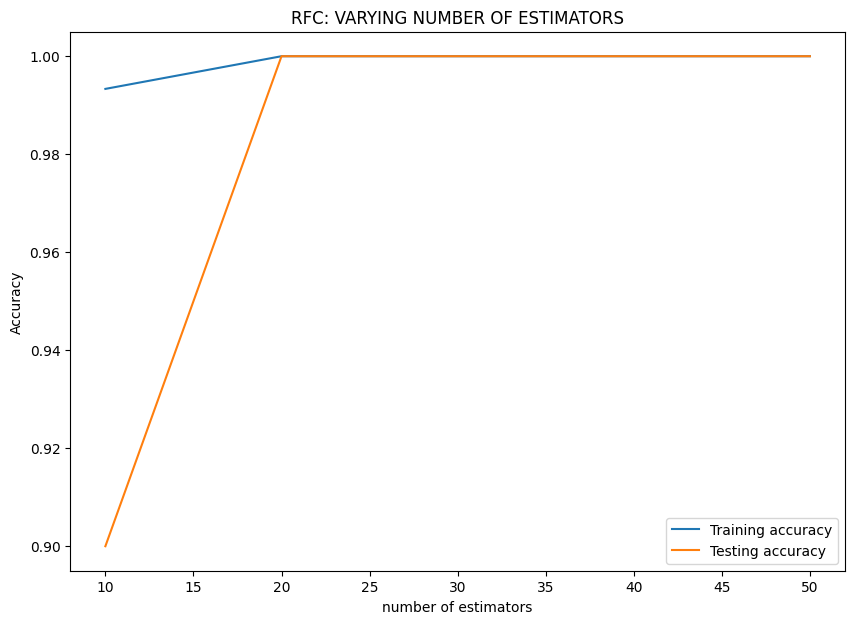

In [22]:
plt.figure(figsize=(10,7))

plt.title('RFC: VARYING NUMBER OF ESTIMATORS')
plt.plot(sizes, train_accuracies.values(), label='Training accuracy')
plt.plot(sizes, test_accuracies.values(), label='Testing accuracy')
plt.legend()

plt.xlabel('number of estimators')
plt.ylabel('Accuracy')
plt.show()

#Probamos el modelo DecisionTreeClassifier variando la profundidad del arbol
Procedemos a hacer algo similar a lo que hicimos con el randomforest, pero esta vez vamos a trabajar con el DecisionTreeClassifier, que nos permite variar la profundidad, por lo cual hacemos eso en un rango de valores que creamos óptimos.

In [23]:
train_accuracies = {}
test_accuracies = {}
sizes = [1,2,3,4,5]
for size in sizes:
  X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.25, random_state=42, stratify=y)
  tree_classifier = DecisionTreeClassifier(max_depth=size,random_state=42)
  tree_classifier.fit(X_train, y_train)
  train_accuracies[size] = rf_classifier.score(X_train, y_train)
  test_accuracies[size] = rf_classifier.score(X_test, y_test)

#Deducción:
Como comente el datset es demasiado pequeño por lo cual la grafica no muestra todo el potencial que podría, sin embargo podemos comprobar que este modelo se adapta mejor a este tipo de problemas mas sencillos ya que en el numero más bajo de profundidad alcanzo una precisión del 100%

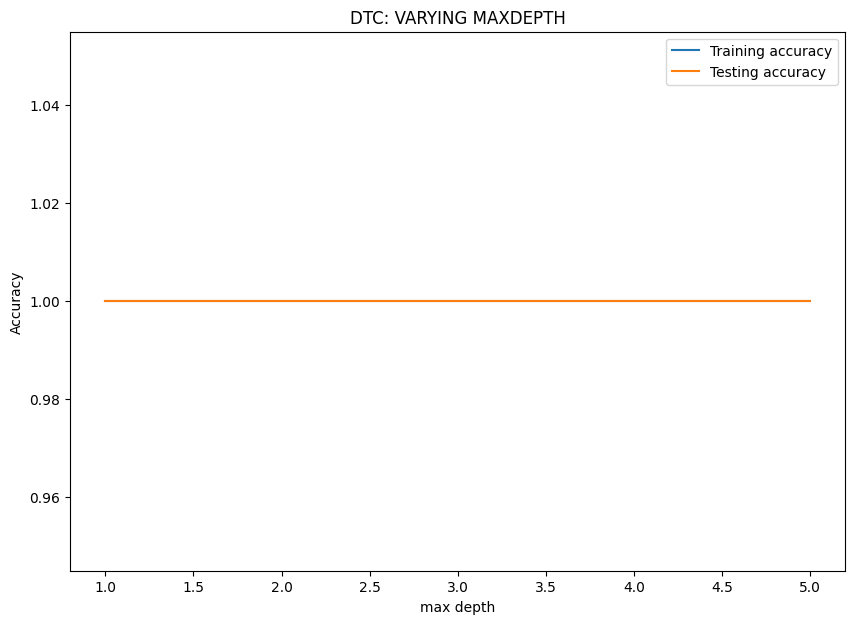

In [24]:
plt.figure(figsize=(10,7))

plt.title('DTC: VARYING MAXDEPTH')
plt.plot(sizes, train_accuracies.values(), label='Training accuracy')
plt.plot(sizes, test_accuracies.values(), label='Testing accuracy')
plt.legend()

plt.xlabel('max depth')
plt.ylabel('Accuracy')
plt.show()

# Conclusión
Primeramente queria demostrar que estos metodos nos pueden permitir ajustar los parametros de las funciones de una manera eficiente y que nos puede permitir seleccionar un modelo que sea equilibrado tanto en los datos de entrenamiento como en los de prueba, y nada que estas funciones tienen mucho potencial y queria hacer una prueba de ello.